# Batch Active Learning

While it is possible to perform rudimentary data selection simply by randomly choosing samples, the batch of data thus drawn might not be the most informative one.
Choosing those samples with the largest prediction uncertainties from trajectories often results in the selection of configurations from subsequent time steps.

Batch selection methods can be constructed to select informative and diverse data, with or without following the underlying distribution.

We will illustrate this in a mock learning on the fly setup.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import yaml
from ase import units
from ase.io import read
from ase.io.trajectory import TrajectoryWriter
from ase.md.langevin import Langevin
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.optimize.fire import FIRE

from apax.bal import api
from apax.md import ASECalculator
from apax.utils.datasets import download_md22_benzene_CCSDT, mod_md_datasets
from apax.utils.helpers import mod_config

E0000 00:00:1732125763.498333  463862 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732125763.501418  463862 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Dataset Acquisition

In [2]:
# Download CCSD(T) Data
data_path = Path("project")
cc_train_file_path, cc_val_file_path = download_md22_benzene_CCSDT(data_path)
cc_train_file_path = mod_md_datasets(cc_train_file_path)
cc_val_file_path = mod_md_datasets(cc_val_file_path)

## Model Training

Unlike simpler data selection methods, such as random selection, we first need to train a model.
It is the representation learned by the model which will serve as the basis for our similarity metric.

In [3]:
!apax template train --full

There is already a config file in the working directory.


In [4]:
config_path = Path("config_full.yaml")

config_updates = {
    "n_epochs": 200,
    "data": {
        "batch_size": 4,
        "valid_batch_size": 100,
        "experiment": "benzene",
        "directory": "project/models",
        "train_data_path": str(cc_train_file_path),
        "val_data_path": str(cc_val_file_path),
        "data_path": None,
        "energy_unit": "kcal/mol",
        "pos_unit": "Ang",
    },
}
config_dict = mod_config(config_path, config_updates)

with open("config_full.yaml", "w") as conf:
    yaml.dump(config_dict, conf, default_flow_style=False)

In [5]:
!apax train config_full.yaml

E0000 00:00:1732125768.132223  463950 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732125768.135407  463950 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO | 18:02:49 | Running on [CudaDevice(id=0)]
INFO | 18:02:49 | Initializing Callbacks
INFO | 18:02:49 | Initializing Loss Function
INFO | 18:02:49 | Initializing Metrics
INFO | 18:02:49 | Running Input Pipeline
INFO | 18:02:49 | Reading training data file project/benzene_ccsd_t-train_mod.xyz
INFO | 18:02:49 | Reading validation data file project/benzene_ccsd_t-test_mod.xyz
INFO | 18:02:50 | Found n_train: 1000, n_val: 500
INFO | 18:02:50 | Computing per element energy regression.
INFO | 18:02:51 | Building Standard model
INFO | 18:02:51 | initializing 1 model(s)
INFO | 18:02:57 | Initializing Optimizer
INFO | 18:02:57 | Beginning Traini

## Molecular Dynamics / Data Generation

Now we will create a pool of data to select new samples from.
In order to emphasize the selection method used in the next section, we will combine MD and geometry optimization, a common occurrence in learning on the fly.

In [6]:
atoms = read(str(cc_train_file_path), "0")
calc = ASECalculator("project/models/benzene")
atoms.calc = calc

In [7]:
def printenergy(a=atoms):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print(
        "Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  "
        "Etot = %.3feV" % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin)
    )


writer = TrajectoryWriter("project/benzene.traj", "w", atoms)

MaxwellBoltzmannDistribution(atoms, temperature_K=298)
dyn = Langevin(atoms, 0.5 * units.fs, temperature_K=298, friction=0.002)
dyn.attach(writer, interval=100)
dyn.attach(printenergy, interval=1000)
dyn.run(10000)

opt = FIRE(atoms)
opt.attach(writer)
opt.run()

Energy per atom: Epot = -524.783eV  Ekin = 0.035eV (T=273K)  Etot = -524.747eV
Energy per atom: Epot = -524.784eV  Ekin = 0.039eV (T=303K)  Etot = -524.745eV
Energy per atom: Epot = -524.789eV  Ekin = 0.040eV (T=310K)  Etot = -524.749eV
Energy per atom: Epot = -524.786eV  Ekin = 0.037eV (T=285K)  Etot = -524.749eV
Energy per atom: Epot = -524.792eV  Ekin = 0.039eV (T=305K)  Etot = -524.753eV
Energy per atom: Epot = -524.778eV  Ekin = 0.039eV (T=301K)  Etot = -524.739eV
Energy per atom: Epot = -524.780eV  Ekin = 0.053eV (T=413K)  Etot = -524.727eV
Energy per atom: Epot = -524.771eV  Ekin = 0.046eV (T=353K)  Etot = -524.726eV
Energy per atom: Epot = -524.775eV  Ekin = 0.051eV (T=393K)  Etot = -524.724eV
Energy per atom: Epot = -524.776eV  Ekin = 0.049eV (T=382K)  Etot = -524.726eV
Energy per atom: Epot = -524.763eV  Ekin = 0.039eV (T=301K)  Etot = -524.724eV
      Step     Time          Energy          fmax
FIRE:    0 18:03:10    -6297.160709        4.643667
FIRE:    1 18:03:10    -6297.

True

## Selecting New Datapoints

Now it is time to select new data points from our pool.
In the following we choose the last-layer gradient kernel as the similarity metric and the max dist selection method (farthest point sampling) to select 10 datapoints from out pool.

In [8]:
train_atoms = read(str(cc_train_file_path), ":")
pool_atoms = read("project/benzene.traj", ":")

In [9]:
len(pool_atoms)

148

In [10]:
base_fm_options = {"name": "ll_grad", "layer_name": "dense_2"}
selection_method = "max_dist"

bs = 10

selected_indices = api.kernel_selection(
    "project/models/benzene",
    train_atoms,
    pool_atoms,
    base_fm_options,
    selection_method,
    selection_batch_size=bs,
    processing_batch_size=bs,
)

Computing features: 100%|██████████████████████████████████████| 1148/1148 [00:02<00:00, 410.32it/s]


In [11]:
selected_indices

(array([145,  99,  13,  28, 105,   8,   7,   3,  34,  77]),
 array([2.1153207e+04, 8.0031250e+01, 1.9972656e+01, 5.7343750e+00,
        5.0390625e+00, 2.3984375e+00, 2.2890625e+00, 2.0976562e+00,
        1.5156250e+00, 1.2968750e+00], dtype=float32),
 array([[-8.0443577e-08, -3.9290704e-08, -5.0462347e-07, ...,
         -2.8600613e-07, -2.1077530e-12,  1.0578943e+01],
        [-7.8728974e-08, -3.6814725e-08, -4.9945356e-07, ...,
         -2.7572671e-07, -2.1329063e-12,  1.0578943e+01],
        [-7.7208618e-08, -3.9166920e-08, -4.5074782e-07, ...,
         -2.8476998e-07, -2.1711810e-12,  1.0578943e+01],
        ...,
        [-7.8029473e-08, -3.7501913e-08, -5.0669252e-07, ...,
         -2.7671780e-07, -2.1255159e-12,  1.0578943e+01],
        [-7.9816232e-08, -3.9418715e-08, -4.7391208e-07, ...,
         -2.8574479e-07, -2.1665530e-12,  1.0578943e+01],
        [-7.9606153e-08, -3.6622986e-08, -5.3845122e-07, ...,
         -2.7972229e-07, -2.0286058e-12,  1.0578943e+01]], dtype=float32),

In [12]:
energies = np.array([a.get_potential_energy() for a in pool_atoms])
# selected_indices = np.random.randint(0, len(energies), 10)
selection_energies = energies[selected_indices[0]]

As we can see below, the batch selection method only picks a few data points from the optimization part of the pool, indicating that during an optimization the structure of the molecule does not change very much.
Hence, there are not many informative samples to be found in it.

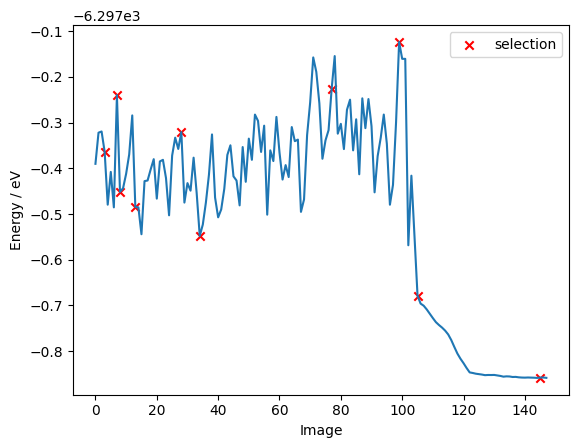

In [13]:
fig, ax = plt.subplots()

ax.plot(energies)
ax.scatter(
    selected_indices[0], selection_energies, marker="x", color="red", label="selection"
)
ax.set_ylabel("Energy / eV")
ax.set_xlabel("Image")
ax.legend()